In [1]:
import os
import sys
import time

import json
import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup as bsoup

try:
    get_ipython()
    from tqdm.notebook import tqdm
except NameError:
    from tqdm import tqdm

In [2]:
from typing import Optional

In [51]:

import subprocess

In [166]:
def subprocess_call(command: str):
    """"""
    return subprocess.Popen(command.split(), stdout=subprocess.PIPE).communicate()


class NordVPN:
    def __init__(self):
        self.status = self.check_status()
        self.group = "unknown"
        self.nord_vpn_command = 'C:\\Program Files\\NordVPN\\NordVPN.exe {args}'
        self.indent = " " * 3

    def check_status(self):
        """"""
        stdout, stderr = subprocess.Popen("netsh interface show interface".split(),
                                          stdout=subprocess.PIPE).communicate()
        vpn_connection_on_value = 'Enabled        Connected      Dedicated        NordLynx'
        for connection in stdout.decode("utf-8").strip().replace("\r", "").split("\n"):
             if vpn_connection_on_value == connection:
                    return True
        return False
    
    def connect(self, group: Optional[str] = None):
        """"""
        if self.check_status() and group == group:
            print("NordVPN already active.")
        else:
            init_command = self.nord_vpn_command.format(args='-c')
            if group:
                init_command += f' -g "{group}"'

            subprocess_call(init_command)

        time.sleep(1)
        assert self.check_status(), "Failed to connect to vpn."
        self.group = group

    def disconnect(self):
        """"""
        if self.check_status:
            subprocess_call(self.nord_vpn_command.format(args='-d'))
        
        assert not self.check_status(), "Failed to disconnect to vpn."
    
    def __repr__(self):
        s = "NordVPN\n"
        s += f"{self.indent}Status: {'Connected.' if self.check_status() else 'Disconnected'}\n"
        if self.group:
            s += f"{self.indent}Group: {self.group}"
        return s


In [160]:
subprocess.run('C:\\Program Files\\NordVPN\\NordVPN.exe -c', capture_output=True)

CompletedProcess(args='C:\\Program Files\\NordVPN\\NordVPN.exe -c', returncode=2, stdout=b'', stderr=b'')

In [161]:
command = 'C:\\Program Files\\NordVPN\\NordVPN.exe -d'
subprocess.Popen(command.split(), stdout=subprocess.PIPE).communicate()

(b'', None)

In [165]:
vpn.check_status()

True

In [167]:
vpn = NordVPN()

In [168]:
vpn.connect()
vpn.disconnect()

NordVPN already active.
True


AssertionError: Failed to disconnect to vpn.

In [146]:
vpn

NordVPN
   Status: Disconnected
   Group: unknown

In [144]:
REQUEST_HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko)'
    ' Chrome/39.0.2171.95 Safari/537.36'
}
ANTI_DOS_DELAY = 0.1


def safe_request(url: str, headers: dict = REQUEST_HEADERS, anti_dos_delay: float = ANTI_DOS_DELAY):
    """"""
    time.sleep(anti_dos_delay)
    try:
        return requests.get(url, headers=REQUEST_HEADERS)
    except requests.exceptions.ConnectionError as e:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return requests.get(url, headers=REQUEST_HEADERS, verify=False)

In [4]:
MICHELIN_GUIDE_URL_FORM = "https://guide.michelin.com/us/en/{state}/{city}/restaurants"

def get_michelin_guide_url(state: str, city: str, stars: Optional[str] = None):
    """"""
    state = state.lower().replace(" ", "-")
    if "new-york" in state:
        state = "new-york-state"
        
    city = city.lower().replace(" ", "-")
    
    if stars:
        stars = stars.replace("+", "-3")
        if "-" in stars:
            lower, upper = stars.split("-")
            stars = range(int(lower), int(upper) + 1)
        else:
            stars = [int(stars)]

        distinctions = ""
        for star in stars:
            if star == 0:
                distinctions += "/bib-gourmand"
            elif star == 1:
                distinctions += f"/{star}-star-michelin"
            else:
                distinctions += f"/{star}-stars-michelin"
            
    
    return MICHELIN_GUIDE_URL_FORM.format(state=state, city=city) + distinctions

In [5]:
url = get_michelin_guide_url("new york", "new york", stars="1")
print(url)

https://guide.michelin.com/us/en/new-york-state/new-york/restaurants/1-star-michelin


In [6]:
MICHELIN_GUIDE_HTML_CLASSES = {
    "total_restaurants": "flex-fill search-results__stats js-restaurant__stats pl-text pl-big",
    "restaurant": "col-md-6 col-lg-6 col-xl-3"
}

def get_michelin_guide_restaurant_html_list(state: str, city: str, stars: Optional[str] = None):
    """"""
    url = get_michelin_guide_url(state=state, city=city, stars=stars)
    
    req = safe_request(url)
    soup = bsoup(req.content, 'html.parser')
    total_restaurants = int(soup.find("div", {"class": MICHELIN_GUIDE_HTML_CLASSES["total_restaurants"]}
                           ).text.split("of")[-1].split("Restaurants")[0].strip())
    
    if total_restaurants <= 0:
        raise ValueError("No restaurants found.")
    
    restaurant_list = soup.find_all("div", {"class": "col-md-6 col-lg-6 col-xl-3"})
    for page_index in range(2, total_restaurants // 20 + 2):
        req = safe_request(url + f"/page/{page_index}")
        if req.status_code != 200:
            break
        
        soup = bsoup(req.content, 'html.parser')
        restaurant_list += soup.find_all("div", {"class": MICHELIN_GUIDE_HTML_CLASSES["restaurant"]})
    
    assert len(restaurant_list) == total_restaurants, \
           f"Incorrect number of restaurants found. Expected {len(total_restaurants)} but got {len(restaurant_list)}"
    
    return restaurant_list

In [7]:
restaurant_html_list = get_michelin_guide_restaurant_html_list("new york", "new york", stars="3")
restaurant_html = restaurant_html_list[0]

In [8]:
import io

def get_image_data_from_url(image_url: str):
    """"""
    response = safe_request(image_url)
    image_bytes = io.BytesIO(response.content)
    return image_bytes


def generate_image_from_data(image_bytes, text = ""):
    """"""
    fig, ax = plt.subplots(figsize=(14, 2))
    a = plt.imread(image_bytes, format="jpg")
    ax.imshow(a)
    plt.axis('off')
#     ax2.text(-1000, 350, text, fontsize=14)
    buf = io.BytesIO()
    #         fig.tight_layout()
    fig.savefig(buf, format='png')
    buf.seek(0)
    restaurant_slide = buf.read()
    plt.close()
    
    return restaurant_slide

In [9]:
GOOGLE_SEARCH_URL_FORM = "https://www.google.com/search?q={search_phrase}"

def google_search_html(search_phrase: str):
    """"""
    search_phrase = search_phrase.replace(" ", "+")
    url = GOOGLE_SEARCH_URL_FORM.format(search_phrase=search_phrase)
    return bsoup(safe_request(url).content, "html.parser")


def get_google_rating(search_phrase: str):
    """"""
    try:
        soup = google_search_html(search_phrase)
        rating = float(soup.find_all("span", {"aria-hidden": "true"})[0].text)
        return rating

    except:
        return None


In [10]:
MICHELIN_HTML_DISTINCTIONS_MAP = {
    "m": "1 Star",
    "n": "2 Stars",
    "o": "3 Stars",
    "=": "Bib Gourmand"
}

class Restaurant:
    """"""
    def __init__(self, restaurant_html):
        self.distinction = MICHELIN_HTML_DISTINCTIONS_MAP[restaurant_html.find("i", {"class": "fa-michelin"}).text]
        
        self.restaurant_urls = restaurant_html.find_all("a")
        self.name = self.restaurant_urls[2]["aria-label"].lstrip("Open ")
        self.michelin_page_url = "https://guide.michelin.com/" + self.restaurant_urls[2]["href"]
        
        self.food_types = restaurant_html.find("div", {"class": "card__menu-footer--price pl-text"}).text
        self.food_types = sorted(set(self.food_types.strip().split(", ")))
        
        req = safe_request(self.michelin_page_url)
        full_page_html = bsoup(req.content, 'html.parser')
        restaurant_info = vars(full_page_html.find("ul", {"class": "restaurant-details__heading--list"}))["contents"]
        
        self.address = restaurant_info[1].text
        info_tokens = restaurant_info[3].text.replace(",", "").split()
        if info_tokens[3] == "USD":
            
            self.cost_str = f"${info_tokens[0]} - ${info_tokens[2]}"
            self.cost = int(info_tokens[2])
            self.food_types = info_tokens[5:]
        else:
            self.cost_str = f"${info_tokens[0]}"
            self.cost = int(info_tokens[0])
            self.food_types = info_tokens[3:]
            

        contact_info = full_page_html.find_all("a", {"class": "link js-dtm-link"})
        try:
            self.phone_number = contact_info[0].get("href", None).lstrip("tel:+1 ")
            self.website = contact_info[1].get("href", None)
        except:
            self.website = None
            self.phone_number = None
                
        self.google_rating = get_google_rating(f"{self.name}+nyc")
        self.image_url = restaurant_html.find_all("a")[0]["data-bg"]
        self.image_data = get_image_data_from_url(self.image_url)
        self.profile_image = generate_image_from_data(self.image_data, text=self.__repr__())
        
#     def __str__(self):
#         s = f"{self.name}\n"
#         s += f"{self.distinction}\n"
#         if self.google_rating:
#             s += f"{self.google_rating} Stars (Google Reviews)\n"
#         s += f"{self.cost_str}\n"
#         s += f"{', '.join(self.food_types)}\n"
#         s += f"{self.phone_number}\n"
#         s += f"{self.website}\n\n"
#         return s
    
    def __repr__(self):
        return f"{self.name} | {self.distinction} | {self.google_rating} Stars (Google Reviews)| {self.cost}"
    
    def __str__(self):
        return f"{self.name} | {self.distinction} | {self.google_rating} Stars (Google Reviews)| {self.cost}"
    
    def __lt__(self, other):
        return self.cost < other.cost
    
    def __le(self, other):
        return self.cost <= other.cost
    
#     def _repr_png_(self):
#         print(self.__repr__())
#         return self.profile_image

In [11]:
Restaurant(restaurant_html_list[1])

Per Se | 3 Stars | 4.6 Stars (Google Reviews)| 355

In [12]:
def get_convert_restaurant_html_list_to_restaurants(restaurant_html_list: list):
    """"""
    desc = "Collecting Restaurant Information"
    return [Restaurant(restaurant_html) for restaurant_html in tqdm(restaurant_html_list, desc=desc, unit=" Restaurant")]

In [13]:
restaurant_html_list = get_michelin_guide_restaurant_html_list("new york", "new york", stars="1+")
restaurant_list = get_convert_restaurant_html_list_to_restaurants(restaurant_html_list)
restaurant_list = sorted(restaurant_list)

# Michelin Star Restaurants

In [14]:
restaurant_data = pd.DataFrame([(restaurant.name, restaurant.cost, restaurant.distinction,
                                 restaurant.google_rating, restaurant) for restaurant in restaurant_list],
                               columns=["name", "cost", "michelin_stars", "google_rating", "restaurant"])

In [15]:
restaurant_data = restaurant_data.sort_values(by=["cost", "google_rating"], ascending=[True, False]).reset_index()
restaurant_data.head(50)

,index,name,cost,michelin_stars,google_rating,restaurant
0,0,Claro,50,1 Star,4.6,Claro | 1 Star | 4.6 Stars (Google Reviews)| 50
1,1,Jeju Noodle Bar,50,1 Star,4.4,Jeju Noodle Bar | 1 Star | 4.4 Stars (Google R...
2,2,Casa Enrique,60,1 Star,4.6,Casa Enrique | 1 Star | 4.6 Stars (Google Revi...
3,5,Kochi,75,1 Star,4.7,Kochi | 1 Star | 4.7 Stars (Google Reviews)| 75
4,8,Don Angie,75,1 Star,4.7,Don Angie | 1 Star | 4.7 Stars (Google Reviews...
5,3,Tuome,75,1 Star,4.6,Tuome | 1 Star | 4.6 Stars (Google Reviews)| 75
6,6,xomoco,75,1 Star,4.6,xomoco | 1 Star | 4.6 Stars (Google Reviews)| 75
7,4,Casa Mono,75,1 Star,4.4,Casa Mono | 1 Star | 4.4 Stars (Google Reviews...
8,7,Kanoyama,75,1 Star,4.3,Kanoyama | 1 Star | 4.3 Stars (Google Reviews)...
9,9,The Four Horsemen,85,1 Star,4.7,The Four Horsemen | 1 Star | 4.7 Stars (Google...


# Bib Gourmand

In [16]:
bib_gourmand_restaurant_html_list = get_michelin_guide_restaurant_html_list("new york", "new york", stars="0")
bib_gourmand_restaurant_list = get_convert_restaurant_html_list_to_restaurants(bib_gourmand_restaurant_html_list)
bib_gourmand_restaurant_list = sorted(bib_gourmand_restaurant_list)

In [26]:
!"C:\Program Files\NordVPN\NordVPN.exe" -c

In [17]:
bib_gourmand_restaurant_data = pd.DataFrame([(restaurant.name, restaurant.cost, restaurant.distinction,
                                 restaurant.google_rating, restaurant) for restaurant in bib_gourmand_restaurant_list],
                               columns=["name", "cost", "michelin_stars", "google_rating", "restaurant"])

bib_gourmand_restaurant_data = bib_gourmand_restaurant_data.sort_values(by=["cost", "google_rating"],
                                                                        ascending=[True, False]).reset_index()
bib_gourmand_restaurant_data.query("google_rating == 4.3").head(50)

,index,name,cost,michelin_stars,google_rating,restaurant
7,0,West New Malaysia,25,Bib Gourmand,4.3,West New Malaysia | Bib Gourmand | 4.3 Stars (...
8,3,Soba-Ya,25,Bib Gourmand,4.3,Soba-Ya | Bib Gourmand | 4.3 Stars (Google Rev...
9,6,Nyonya,25,Bib Gourmand,4.3,Nyonya | Bib Gourmand | 4.3 Stars (Google Revi...
10,7,Mile End,25,Bib Gourmand,4.3,Mile End | Bib Gourmand | 4.3 Stars (Google Re...
11,11,J.G. Melon,25,Bib Gourmand,4.3,J.G. Melon | Bib Gourmand | 4.3 Stars (Google ...
18,15,Mexicosina,30,Bib Gourmand,4.3,Mexicosina | Bib Gourmand | 4.3 Stars (Google ...
29,23,Xilonen,40,Bib Gourmand,4.3,Xilonen | Bib Gourmand | 4.3 Stars (Google Rev...
32,32,Klein's,44,Bib Gourmand,4.3,Klein's | Bib Gourmand | 4.3 Stars (Google Rev...
34,33,Rangoon,45,Bib Gourmand,4.3,Rangoon | Bib Gourmand | 4.3 Stars (Google Rev...
35,36,Beatstro,45,Bib Gourmand,4.3,Beatstro | Bib Gourmand | 4.3 Stars (Google Re...


# Yelp Data Pulling

In [29]:
YELP_API_KEY = "YGZDloqBNKFrYEY5hXc1W9oCwROWm0xtAe93k3_a1dcA8IFy-xkH4c9xxyVoQxKf796DVBLmsR24YkRCf8l73JuWDyuQi5KnV9FVIY_OMo6xFxvSmh07ZG_Vu2z9YXYx"

In [30]:
YELP_API_HOST = 'https://api.yelp.com'
YELP_SEARCH_PATH = '/v3/businesses/search'
YELP_BUSINESS_PATH = '/v3/businesses/'

YELP_DEFAULT_LOCATION = 'NYC'
SEARCH_LIMIT = 3


In [44]:
YELP_REQUEST_HEADER = {
    'Authorization': f'Bearer {YELP_API_KEY}',
}


def get_yelp_restaurants(term: str, location: str = YELP_DEFAULT_LOCATION, **params: dict):
    """
    suggested search terms:
    
    radius: in meters
    limit: max items to return (max value is 50)
    offset: list offset number
    sort_by: best_match, rating, review_count or distance
    price: 1 = $, 2 = $$, 3 = $$$, 4 = $$$$, example: 1,2,4
    
    """
    url_form = YELP_API_HOST + YELP_SEARCH_PATH + "?"
    url_form = f"{url_form}?term={term}&location={location}"
    for key, value in params.items():
        url_form += f"&{key}={value}"

    req = requests.request('GET', url_form, headers=YELP_REQUEST_HEADER)
    return req


def get_all_yelp_restaurants(term: str, location: str = YELP_DEFAULT_LOCATION, top=None, **params: dict):
    """"""
    limit = 50
    
    assert "limit" not in params and "offset" not in params
    
    params["limit"] = limit
    params["offset"] = 0
    restaurant_data = get_yelp_restaurants(term, location=location, **params).json()
    total_restaurants = restaurant_data["total"]
    
    if total_restaurants == 0:
        raise ValueError("No restaurants found.")
    
    if total_restaurants < limit:
        return restaurant_data

    max_index = top // limit if top else total_restaurants // limit
    print(max_index)
    
    pbar = tqdm(total=max_index * 50, unit=" restaurants", desc="Gathering Restaurant Data")
    
    for pull_index in range(max_index):
        params["offset"] += 50
        additional_restaurant_data = get_yelp_restaurants(term, location=location, **params).json()
        restaurant_data["businesses"] += additional_restaurant_data["businesses"]
        time.sleep(1.1)
        pbar.update(50)
    
    return restaurant_data

req = get_yelp_restaurants("restaurant", price="4", sort_by="rating")

In [45]:
data = get_all_yelp_restaurants("restaurant", price="1", sort_by="rating", location="NYC", top=500)

10


Gathering Restaurant Data:   0%|          | 0/500 [00:00<?, ? restaurants/s]

In [ ]:
for restaurant in tqdm(data["businesses"]):
    pass

In [46]:
columns = ['name', 'review_count', 'rating', 'id', 'alias']

restaurant_list = []
for restaurant in data["businesses"]:
    row = [restaurant[key] for key in columns]
    row.append(", ".join(item["title"] for item in restaurant["categories"]))
    row.append(", ".join(restaurant["location"]["display_address"]))
    restaurant_list.append(row)
    
restaurant_data = pd.DataFrame(restaurant_list, columns=columns + ["categories", "address"])

(array([ 39.,   0.,   0.,   0.,   0., 439.,   0.,   0.,   0.,  72.]),
 array([4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 <a list of 10 Patch objects>)

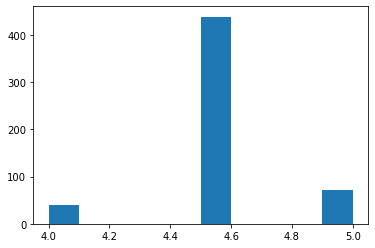

In [47]:
plt.hist(restaurant_data["rating"])

In [ ]:
restaurant_data["alias"].apply(get_google_rating)

In [59]:
t = YelpRestaurant(data["businesses"][0])
vars(t)

{'id': 'nSUIB7itn5ufTUzwa1IgxA',
 'alias': 'frenchys-food-truck-brooklyn',
 'name': "Frenchy's Food Truck",
 'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/JSj17pVzTpGQckEOwQQcaw/o.jpg',
 'is_closed': False,
 'url': 'https://www.yelp.com/biz/frenchys-food-truck-brooklyn?adjust_creative=sG31Ey8qhS-SEDtpnF48eQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=sG31Ey8qhS-SEDtpnF48eQ',
 'review_count': 89,
 'categories': [{'alias': 'coffee', 'title': 'Coffee & Tea'},
  {'alias': 'foodtrucks', 'title': 'Food Trucks'},
  {'alias': 'cakeshop', 'title': 'Patisserie/Cake Shop'}],
 'rating': 5.0,
 'coordinates': {'latitude': 40.6706988393431, 'longitude': -73.9577984064817},
 'transactions': [],
 'price': '$',
 'location': {'address1': '341 Eastern Pkwy',
  'address2': '',
  'address3': None,
  'city': 'Brooklyn',
  'zip_code': '11238',
  'country': 'US',
  'state': 'NY',
  'display_address': ['341 Eastern Pkwy', 'Brooklyn, NY 11238']},
 'phone': '+16464682861',
 'disp

In [57]:
class YelpRestaurant:
    def __init__(self, yelp_data: dict):
        for key, value in yelp_data.items():
            self.__dict__[key] = value
        
        self.google_rating = get_google_rating(f"{self.alias}")

In [54]:
data["businesses"][3]

{'id': 'ytYVlCkrzcAxxUcbT4NTgA',
 'alias': 'juice-vitality-new-york',
 'name': 'Juice Vitality',
 'image_url': 'https://s3-media3.fl.yelpcdn.com/bphoto/HhD3Bp3axBZfxcdV4aIW0g/o.jpg',
 'is_closed': False,
 'url': 'https://www.yelp.com/biz/juice-vitality-new-york?adjust_creative=sG31Ey8qhS-SEDtpnF48eQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=sG31Ey8qhS-SEDtpnF48eQ',
 'review_count': 208,
 'categories': [{'alias': 'juicebars', 'title': 'Juice Bars & Smoothies'},
  {'alias': 'bubbletea', 'title': 'Bubble Tea'},
  {'alias': 'acaibowls', 'title': 'Acai Bowls'}],
 'rating': 5.0,
 'coordinates': {'latitude': 40.72966, 'longitude': -73.9834},
 'transactions': ['pickup', 'delivery'],
 'price': '$',
 'location': {'address1': '192 1st Ave',
  'address2': None,
  'address3': '',
  'city': 'New York',
  'zip_code': '10009',
  'country': 'US',
  'state': 'NY',
  'display_address': ['192 1st Ave', 'New York, NY 10009']},
 'phone': '+12124770071',
 'display_phone': '(212) 4